In [209]:
import numpy as np
from itertools import chain,groupby
from glob import glob
import random
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [210]:
# groupby return value and subgroup,subgroup is also a iterable,change it to list to get the length of it
def run_length_encoding(it):
    return list(chain.from_iterable(
            (value,len(list(sub_it))) 
            for value,sub_it in groupby(it)))

#in fact, only mask need to be returned, so RLE can only count 255 rather than count both 0 and 255
# The pixels are one-indexed and numbered from top to bottom, then left to right as the dataset mask is encoded,
# so I use flatten(order='F')
def mask_encoding(mask):
    mask = np.array(mask)
    shape = mask.shape
    it = mask.flatten(order='F')
    start_point = 1;
    rle = []
    for value, sub_it in groupby(it):
        length = len(list(sub_it))
        if value == 255:
            rle.append(start_point)
            rle.append(length)
        start_point += length
    return rle,shape

def mask_decoding(rle,shape):
    mask = np.zeros(shape).flatten(order='F')
    i = 0;
    total_length = len(rle)
    while(i < total_length):
        place,length = rle[i]-1,rle[i+1]
        mask[place:place+length] = 255
        i += 2
    return mask.reshape(shape,order='F')

In [211]:
masks = glob('./stage1_train/*/masks/*')

./stage1_train/55ff2b0ec48b76e10c7ee18add5794005cd551697f96af865c763d50da78dd9c/masks/2ad392d69824b3f1e2c896164f6f9d1c8381eca95a2ae8529802bc3c62192fac.png
(256, 256)
RLE: [23759, 4, 24014, 7, 24269, 10, 24523, 13, 24778, 14, 25034, 15, 25289, 17, 25544, 18, 25799, 20, 26055, 20, 26311, 19, 26567, 19, 26823, 19, 27080, 18, 27337, 17, 27593, 16, 27849, 16, 28106, 15, 28363, 13, 28620, 11, 28879, 7] 



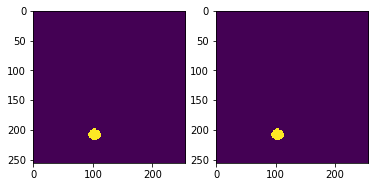

In [212]:
rand_mask_path = random.choice(masks)
print(rand_mask_path)
mask = np.array(Image.open(rand_mask_path))
print(mask.shape)
plt.subplot(121)
plt.imshow(mask)

rle,shape = mask_encoding(mask)
print('RLE:',rle,'\n')
mask_recover = mask_decoding(rle,shape)
plt.subplot(122)
plt.imshow(mask_recover)

plt.show()

In [184]:
import csv

In [185]:
csv_file_path = './stage1_train_labels.csv'
csv_dict = {}
with open(csv_file_path,'r',newline='') as csvfile:
    RLE_reader = csv.reader(csvfile,delimiter=',')
    label = next(RLE_reader)
    for img_id,rle in RLE_reader:
        if not csv_dict.get(img_id):
            csv_dict[img_id] = []
        rle = list(map(int, rle.split()))
        csv_dict[img_id].append(rle)

[25560, 5, 25815, 7, 26070, 8, 26325, 9, 26581, 9, 26837, 9, 27093, 9, 27350, 8, 27606, 7, 27863, 3]


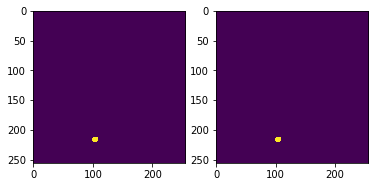

In [186]:
img_id = '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'
all_masks = csv_dict[img_id]
image_masks_path = glob('./stage1_train/'+img_id+'/masks/*')
single_mask_path = image_masks_path[0]
mask = np.array(Image.open(single_mask_path))
plt.subplot(121)
plt.imshow(mask)
rle,shape = mask_encoding(mask)
print(rle)
plt.subplot(122)
plt.imshow(mask_decoding(rle,shape))
plt.show()

In [203]:
#here, I want to find a image having smallest num of mask
# imgs = glob('./stage1_train/*')
# s = 1e6
# fit = None
# for img in imgs:
#     mask_paths = glob(img+'/masks/*')
#     if len(mask_paths) < s:
#         s = len(mask_paths)
#         fit = img
# masks_path = glob(fit+'/masks/*')

offical encoding: [46326, 11, 46579, 14, 46833, 16, 47087, 18, 47343, 18, 47598, 19, 47854, 19, 48110, 18, 48367, 15, 48623, 12, 48879, 9, 49136, 6]
    My encoding : [46326, 11, 46579, 14, 46833, 16, 47087, 18, 47343, 18, 47598, 19, 47854, 19, 48110, 18, 48367, 15, 48623, 12, 48879, 9, 49136, 6]


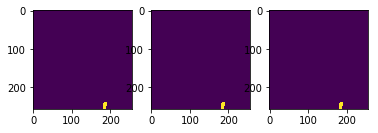

In [213]:
# image contain only one mask to make sure my encoding is right
# img_id = '84eeec681987753029eb83ea5f3ff7e8b5697783cdb2035f2882d40c9a3f1029'
# fit = './stage1_train/'+img_id
# fit_img_path = glob(fit+'/images/*')[0]
# fit_mask_path = glob(fit+'/masks/*')[0]
# mask_rle = csv_dict[img_id][0]
# print('offical encoding:',mask_rle)
# orignal_mask = np.array(Image.open(fit_mask_path))
# plt.subplot(131)
# plt.imshow(orignal_mask)

# rle,shape = mask_encoding(orignal_mask)
# print('    My encoding :',rle)
# plt.subplot(132)
# plt.imshow(mask_decoding(rle,shape))

# plt.subplot(133)
# plt.imshow(mask_decoding(mask_rle,shape))
# plt.show()

In [ ]:
## get one mask for one image
def mask_joint(mask_paths):
    mask = np.array(Image.open(mask_paths[0]))
    joint_mask = np.zeros_like(mask)
    for path in mask_paths:
        joint_mask += np.array(Image.open(path))
    return joint_mask

imgs = glob('./stage1_train/*')
for img_path in imgs:
    mask_paths = glob(img_path + '/masks/*')
    one_mask = mask_joint(mask_paths)
    plt.imshow(one_mask)
    plt.show()
    im = Image.fromarray(one_mask)
    im.save(img_path + '/whole_mask.PNG','PNG')

In [207]:
# put image in the right place
imgs = glob('./stage1_train/*')
print(len(imgs))
# for img_path in imgs:
#     im = Image.open(glob(img_path + '/images/*')[0])
#     img_path = img_path + '/original.PNG'
#     im.save(img_path,'PNG')

670
